In [1]:
pip install ReliefF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 914.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ReliefF: filename=ReliefF-0.1.2-py3-none-any.whl size=6303 sha256=d6fd88ce9d32aa96fbb49b2f9e293d76de4e2301c061e44d7469d9c70db0cd1b
  Stored in directory: /root/.cache/pip/wheels/35/bc/0b/14a0227d4829b6b27f25de250213eb348b094d075be7604707
Successfully built ReliefF


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: line 1: google-drive-ocamlfuse: command not found


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve,roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing # Import label encoder

# Feature Importance
from ReliefF import ReliefF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE

np.random.seed(42)

# FUNCTIONS

## Feature Selection Functions

In [125]:
def get_features_reliefF(data, target, n_features_to_select):
  fs = ReliefF(n_neighbors=1, n_features_to_keep=n_features_to_select)
  features = fs.fit_transform(data.to_numpy(), target.to_numpy()).T

  columns = data.columns.to_list()
  reliefF_features = []
  for feature in features:
      for column in columns:
        idx = (data[column] == feature)
        if idx.all() == True:
          reliefF_features.append(column)
          break

  #print('Top-10 features: \n', reliefF_features)
  return reliefF_features

def get_features_chi2(data, target, number_of_features):
  features_norm = MinMaxScaler().fit_transform(data)
  chi_selector = SelectKBest(chi2, k=number_of_features)
  chi_selector.fit(features_norm, target)

  chi_support = chi_selector.get_support()
  chi_feature = data.loc[:,chi_support].columns.tolist()
  #print('Top-10 features: \n', chi_feature)
  return chi_feature

def get_features_rfe(data, target, number_of_features):
  features_norm = MinMaxScaler().fit_transform(data)
  rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=number_of_features, step=10, verbose=5)
  rfe_selector.fit(features_norm, target)

  rfe_support = rfe_selector.get_support()
  rfe_features = data.loc[:,rfe_support].columns.tolist()
  #print('Top-10 features: \n', rfe_features)
  return rfe_features

def get_features_infoGain(data, target, number_of_features):
  # determine the mutual information
  mutual_info = mutual_info_classif(data, target)

  mutual_info = pd.Series(mutual_info)
  mutual_info.index = data.columns
  mutual_info.sort_values(ascending=False)

  # Select the  top 10 important features
  sel_ten_cols = SelectKBest(mutual_info_classif, k=number_of_features)
  sel_ten_cols.fit(data, target)
  infoGain_features = data.columns[sel_ten_cols.get_support()].to_list()
  #print('Top-10 features: \n', infoGain_features)
  return infoGain_features

def get_features_dt(data, target, number_of_features):
  # Initialize the DecisionTreeClassifier
  clf = DecisionTreeClassifier()

  # Scale data
  scaler = StandardScaler().fit(data)
  data_scaled = scaler.transform(data)
  # Fit the classifier on the data
  clf.fit(data_scaled, target)

  # Get the feature importances
  feature_importances = clf.feature_importances_

  # Sort the feature importances and get the top 10 features
  top_10_features = pd.DataFrame(feature_importances, index=data.columns, columns=['Importance']).sort_values(by='Importance', ascending=False).head(number_of_features)

  # Return the names of the top 10 features
  dt_features = top_10_features.index.to_list()
  return dt_features

def get_features_wrapper(classifier, number_of_features):
  # Initialize an empty set to hold the selected features
  selected_features = set()

  # Repeat the following steps until ten features have been selected
  while len(selected_features) < number_of_features:
      best_accuracy = 0
      best_feature = None

      # Iterate over all features that have not been selected yet
      for feature in X_train.columns:
          if feature not in selected_features:
              # Train the classifier using the selected features plus the current feature
              classifier.fit(X_train[list(selected_features) + [feature]], y_train)

              # Make predictions on the test set
              y_pred = classifier.predict(X_test[list(selected_features) + [feature]])

              # Calculate the accuracy
              accuracy = accuracy_score(y_test, y_pred)

              # Check if this feature leads to the best accuracy so far
              if accuracy > best_accuracy:
                  best_accuracy = accuracy
                  best_feature = feature

      # Add the best feature to the set of selected features
      selected_features.add(best_feature)

      # Print the best feature and its accuracy
      # print(f"Selected feature: {best_feature}, Accuracy: {best_accuracy:.2f}")
  #print(sorted(selected_features))
  return selected_features


def filter_selected_features(features):
  X_train_selected = X_train[features]
  X_test_selected = X_test[features]
  return X_train_selected, X_test_selected

## Metrics

In [6]:
def get_percision_recall_scores(y_test, y_pred, algorithm_name):
    rs=recall_score(y_test, y_pred)
    ps=precision_score(y_test, y_pred)

    print("\n")
    print("Recall Score of ", algorithm_name, " : ",rs)
    print("Precision Score of ", algorithm_name, " : ",ps)
    print()

def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr,tpr, color='red',label = roc_auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

def conf_mtrx(y_test, y_pred, model):

    cm = confusion_matrix(y_test,y_pred)

    f, ax = plt.subplots(figsize =(5,5))
    cm = confusion_matrix(y_test,y_pred)

    sns.heatmap(cm,annot = True, linewidths=0.5, linecolor="red",fmt = ".0f",ax=ax)
    plt.xlabel("predicted y values")
    plt.ylabel("real y values")
    plt.title("\nConfusion Matrix")
    plt.show()

# Function for machine learning algorithms

def ML_Algorithms(X_train, X_test, y_train, y_test, alg_name, model ,value):

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)


    conf_mtrx(y_test, y_pred, model)
    print(" ")
    print("*****",alg_name," ALGORITHM:")

    print("Score for ", alg_name," train set:"  ,  model.score(X_train,y_train))
    print("Score for ", alg_name, " test set: ", model.score(X_test,y_test))
    print(" ")

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(" ")

    print(" ")
    print("F1-score: ", f1_score(y_test, y_pred, average='weighted'))
    print(" ")

    if(value==1):
        get_percision_recall_scores(y_test, y_pred, alg_name)

        tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
        y_prob = model.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities
        y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)

        probs = model.predict_proba(X_test)
        probs = probs[:, 1]

        auc = roc_auc_score(y_test, probs)
        print('AUC: %.2f' % auc)

        auc = roc_auc_score(y_test, probs)
        print('AUC: %.2f' % auc)
        plot_roc_curve(fpr, tpr)

# DATASET

In [7]:
data = pd.read_csv('drive/MyDrive/TEZ/autism-code/DuyguDurumları_veriseti/1_MutluDataSET.csv')
data.head(5) # To display the top 5 rows

,Participant,M Y1,M Y2,M Y3,M Y4,M Y5,M Y6,M Y7,M Y8,M Y9,...,X_B4,X_B5,X_B6,X_B7,X_B8,X_B9,X_B10,X_B11,X_B12,Class
0,ahi,2784.15,2516.10,2770.45,3018.25,161.90,5.0,8.0,15.45,14.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,OSB
1,aden1,2955.70,4281.70,4405.70,4614.05,762.15,4.0,5.5,16.40,23.80,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,NG
2,bulem dogan ng 18,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,...,1711.80,1076.00,2.0,2.0,7.95,8.1,1459.90,8.1,729.90,OSB
3,aras22,2190.15,2323.85,2443.90,2541.80,200.00,2.5,3.0,12.20,12.90,...,56.00,0.00,0.0,0.0,0.90,0.0,0.00,0.0,0.00,NG
4,meric arda,7961.75,8119.70,8433.75,8691.80,1452.10,6.0,8.5,44.25,45.05,...,140.05,72.05,0.5,0.5,0.60,0.4,72.05,0.4,72.05,NG


In [8]:
data = data.drop(['Participant'], axis=1) # remove participant column

In [9]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'Class'. OSB is 1, NG is 0
data['Class']= label_encoder.fit_transform(data['Class'])

data['Class'].unique()

array([1, 0])

In [10]:
y = data.pop('Class')

# SPLIT DATA

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=33)

In [12]:
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 99
Testing records: 25


In [13]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection:

Trying different approaches:

- ReliefF
- Chi-2;
- RFE;
- Information Gain;
- Decision Tree;
- Wrapper;
  - Decision Tree
  - Gaussion NB
  - k-NN

## ReliefF

In [14]:
reliefF_features = get_features_reliefF(data, y, 20)

## Chi-squared

In [15]:
chi_feature = get_features_chi2(data, y, 20)

## Recursive Feature Removal

In [16]:
rfe_features = get_features_rfe(data, y, 20)

Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.
Fitting estimator with 22 features.


## Information Gain

In [17]:
infoGain_features = get_features_infoGain(data, y, 20)

## Decision Tree

In [18]:
dt_features = get_features_dt(data, y, 20)

## Wrapper
- Decision Tree
- Gaussian NB
- k-NN

In [19]:
wrapper_dt_features = get_features_wrapper(DecisionTreeClassifier(criterion='entropy'), 20)
wrapper_NB_features = get_features_wrapper(GaussianNB(), 20)
wrapper_knn_features = get_features_wrapper(KNeighborsClassifier(n_neighbors=5), 20)

In [33]:
print("Selected features from chi:         ", sorted(chi_feature))
print("Selected features from rfe:         ", sorted(rfe_features))
print("Selected features from reliefF:     ", sorted(reliefF_features))
print("Selected features from infoGain:    ", sorted(infoGain_features))
print("Selected features from dt:          ", sorted(dt_features))
print("Selected features from wrapper DT:  ", sorted(wrapper_dt_features))
print("Selected features from wrapper NB:  ", sorted(wrapper_NB_features))
print("Selected features from wrapper knn: ", sorted(wrapper_knn_features))

Selected features from chi:          ['DA 1', 'DA 10', 'DA 11', 'DA 2', 'DA 3', 'DA 4', 'DA 8', 'DA 9', 'M Y1', 'M Y10', 'M Y11', 'M Y12', 'M Y2', 'M Y3', 'M Y4', 'M Y6', 'M Y8', 'M Y9', 'X_Y12', 'X_Y5']
Selected features from rfe:          ['DA 10', 'DA 11', 'DA 12', 'DA 2', 'DA 6', 'M B6', 'M B7', 'M Y10', 'M Y11', 'M Y2', 'M Y3', 'M Y4', 'M Y6', 'M Y9', 'N5', 'N6', 'X_Y12', 'X_Y5', 'X_Y6', 'X_Y7']
Selected features from reliefF:      ['DA 7', 'DA 8', 'M B1', 'M B10', 'M B11', 'M B12', 'M B2', 'M B3', 'M B4', 'M B5', 'M B6', 'M B7', 'M B9', 'M Y1', 'M Y7', 'N7', 'X_Y1', 'X_Y11', 'X_Y2', 'X_Y6']
Selected features from infoGain:     ['DA 10', 'DA 11', 'DA 12', 'M B6', 'M Y1', 'M Y10', 'M Y11', 'M Y12', 'M Y2', 'M Y3', 'M Y4', 'M Y8', 'M Y9', 'X_B4', 'X_B9', 'X_Y10', 'X_Y11', 'X_Y12', 'X_Y2', 'X_Y5']
Selected features from dt:           ['DA 10', 'DA 11', 'DA 5', 'DA 7', 'DA 8', 'DA 9', 'M B2', 'M B6', 'M B7', 'M Y7', 'M Y9', 'N1', 'N3', 'N5', 'N7', 'X_B12', 'X_B8', 'X_Y11', 'X_Y5', 'X_

## SELECT THE FEATURE SELECTION METHOD FOR THE MODELS


In [114]:
# X_train_selected, X_test_selected = filter_selected_features(chi_feature)
# X_train_selected, X_test_selected = filter_selected_features(rfe_features)
# X_train_selected, X_test_selected = filter_selected_features(reliefF_features)
# X_train_selected, X_test_selected = filter_selected_features(infoGain_features)
# X_train_selected, X_test_selected = filter_selected_features(dt_features)
# X_train_selected, X_test_selected = filter_selected_features(wrapper_dt_features)
# X_train_selected, X_test_selected = filter_selected_features(wrapper_NB_features)
# X_train_selected, X_test_selected = filter_selected_features(wrapper_knn_features)

<ipython-input-34-78aa4cc14b94>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_selected = X_train[features]
<ipython-input-34-78aa4cc14b94>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_selected = X_test[features]


In [128]:
# common_features = [
# 'DA 7',
# 'DA 8',
# 'DA 10',
# 'DA 11',
# 'M Y1',
# 'M Y2',
# 'M Y6',
# 'M Y7',
# 'M Y8',
# 'M Y9',
# 'M Y11',
# 'M B6',
# 'M B7',
# 'X_Y5',
# 'X_Y6',
# 'N7']
# X_train_selected, X_test_selected = filter_selected_features(common_features)

In [129]:
scaler = StandardScaler().fit(X_train_selected)
X_train_scaled = scaler.transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# ML MODELS

## DECISION TREE

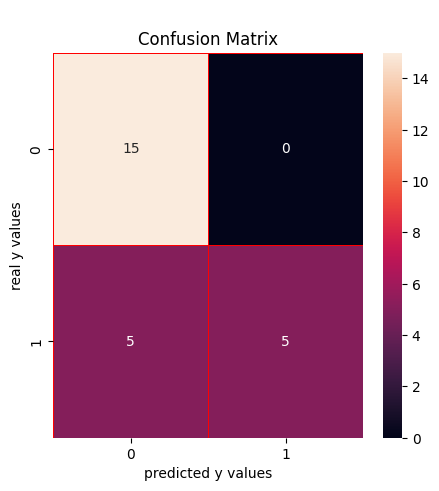

 
***** DECISION TREE CLASSIFIER  ALGORITHM:
Score for  DECISION TREE CLASSIFIER  train set: 0.7676767676767676
Score for  DECISION TREE CLASSIFIER  test set:  0.8
 
Accuracy: 80.00%
 
 
F1-score:  0.7809523809523808
 


Recall Score of  DECISION TREE CLASSIFIER  :  0.5
Precision Score of  DECISION TREE CLASSIFIER  :  1.0

AUC: 0.69
AUC: 0.69


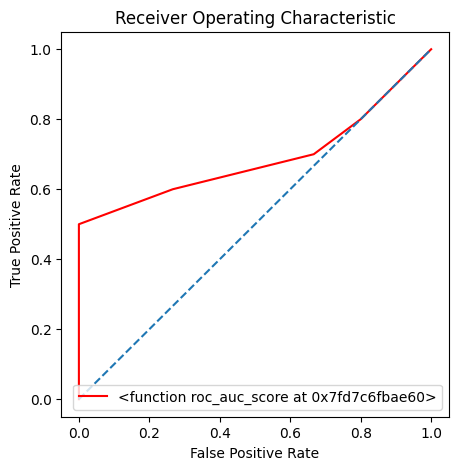

In [130]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "DECISION TREE CLASSIFIER",
              DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=7, min_samples_leaf=10, random_state=42), 1)

## RANDOM FOREST

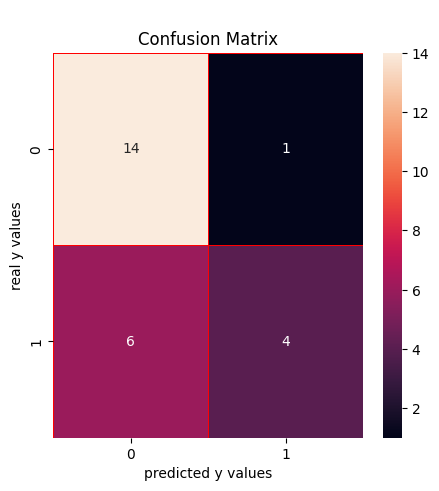

 
***** RANDOM FOREST CLASSIFIER  ALGORITHM:
Score for  RANDOM FOREST CLASSIFIER  train set: 0.8484848484848485
Score for  RANDOM FOREST CLASSIFIER  test set:  0.72
 
Accuracy: 72.00%
 
 
F1-score:  0.6933333333333332
 


Recall Score of  RANDOM FOREST CLASSIFIER  :  0.4
Precision Score of  RANDOM FOREST CLASSIFIER  :  0.8

AUC: 0.63
AUC: 0.63


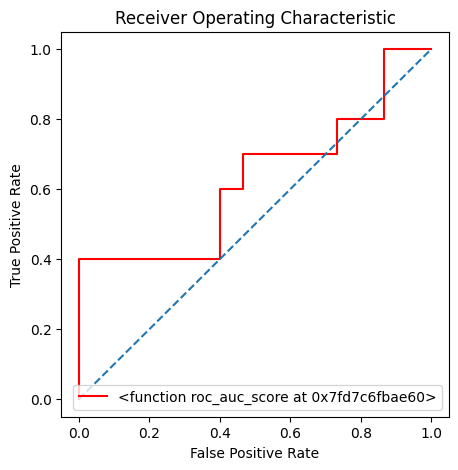

In [131]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "RANDOM FOREST CLASSIFIER",
              RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42),1)

## LOGISTIC REGRESSION

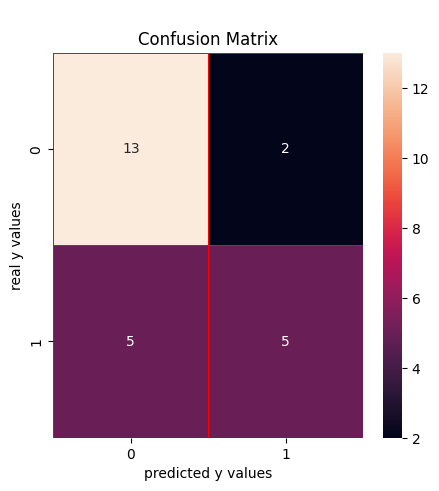

 
***** LOGISTIC REGRESSION  ALGORITHM:
Score for  LOGISTIC REGRESSION  train set: 0.7777777777777778
Score for  LOGISTIC REGRESSION  test set:  0.72
 
Accuracy: 72.00%
 
 
F1-score:  0.7080213903743313
 


Recall Score of  LOGISTIC REGRESSION  :  0.5
Precision Score of  LOGISTIC REGRESSION  :  0.7142857142857143

AUC: 0.74
AUC: 0.74


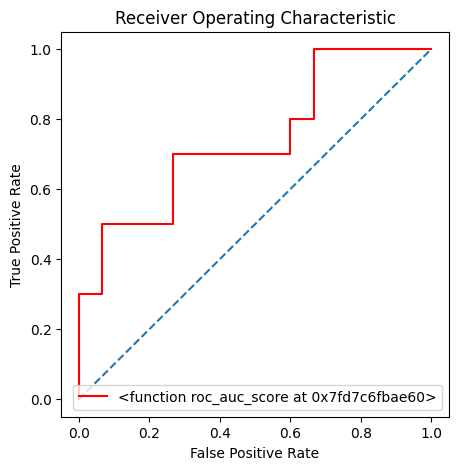

In [132]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "LOGISTIC REGRESSION",
              LogisticRegression(C=100.0, penalty='l2', solver='liblinear'),1)

## NAIVE BAYES

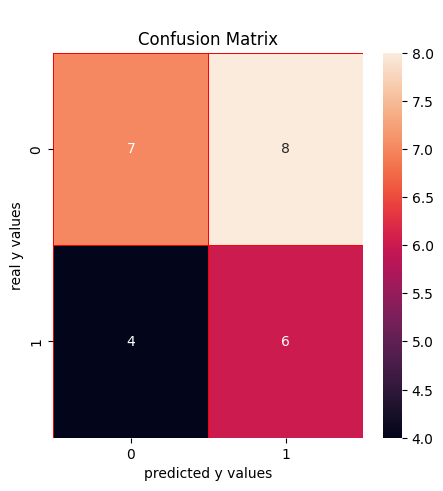

 
***** Bernoulli NB  ALGORITHM:
Score for  Bernoulli NB  train set: 0.6868686868686869
Score for  Bernoulli NB  test set:  0.52
 
Accuracy: 52.00%
 
 
F1-score:  0.5230769230769231
 


Recall Score of  Bernoulli NB  :  0.6
Precision Score of  Bernoulli NB  :  0.42857142857142855

AUC: 0.52
AUC: 0.52


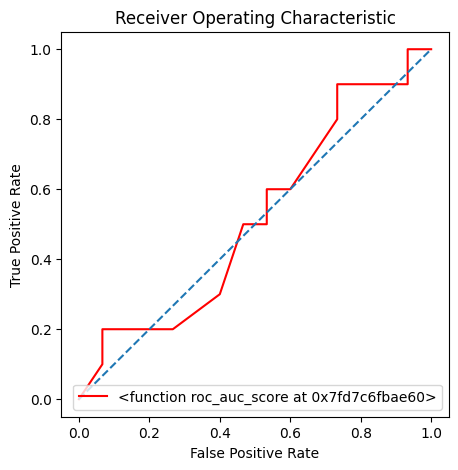

In [133]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "Bernoulli NB",
              BernoulliNB(alpha=0.0001, binarize=0.9),1)

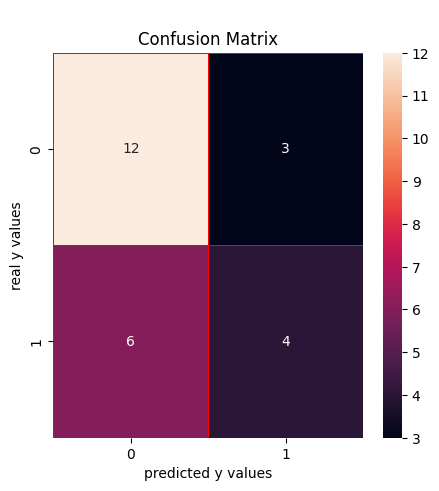

 
***** GAUSSIAN NB  ALGORITHM:
Score for  GAUSSIAN NB  train set: 0.6666666666666666
Score for  GAUSSIAN NB  test set:  0.64
 
Accuracy: 64.00%
 
 
F1-score:  0.6245989304812833
 


Recall Score of  GAUSSIAN NB  :  0.4
Precision Score of  GAUSSIAN NB  :  0.5714285714285714

AUC: 0.68
AUC: 0.68


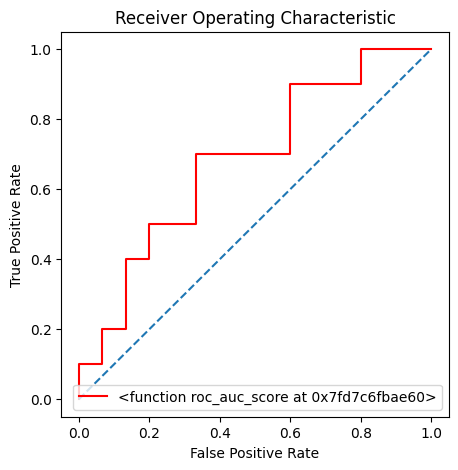

In [134]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "GAUSSIAN NB",
              GaussianNB(),1)

## KNN

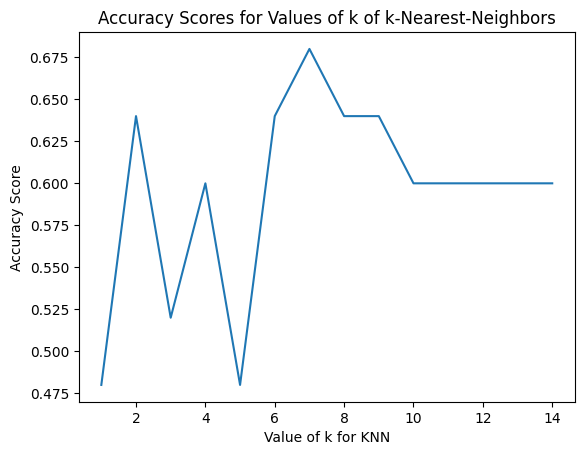

In [135]:
# knn hyperparameter tuning / determine k

k_range = list(range(1,15))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

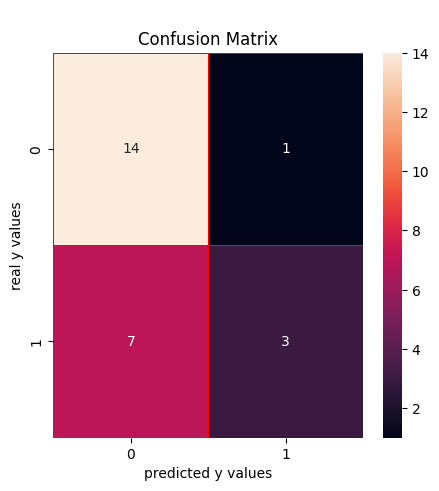

 
***** K-NEIGHBORS CLASSIFIER  ALGORITHM:
Score for  K-NEIGHBORS CLASSIFIER  train set: 0.7676767676767676
Score for  K-NEIGHBORS CLASSIFIER  test set:  0.68
 
Accuracy: 68.00%
 
 
F1-score:  0.638095238095238
 


Recall Score of  K-NEIGHBORS CLASSIFIER  :  0.3
Precision Score of  K-NEIGHBORS CLASSIFIER  :  0.75

AUC: 0.63
AUC: 0.63


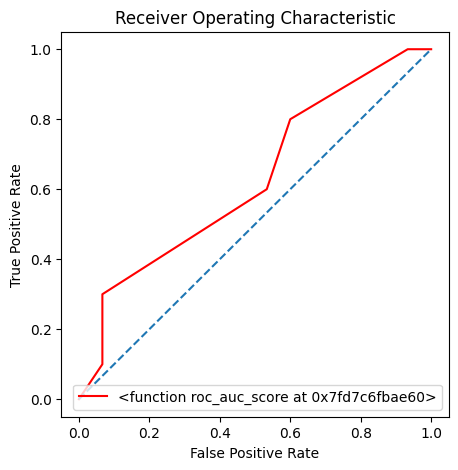

In [136]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "K-NEIGHBORS CLASSIFIER",
              KNeighborsClassifier(n_neighbors=7),1)

## Gradient Boosting

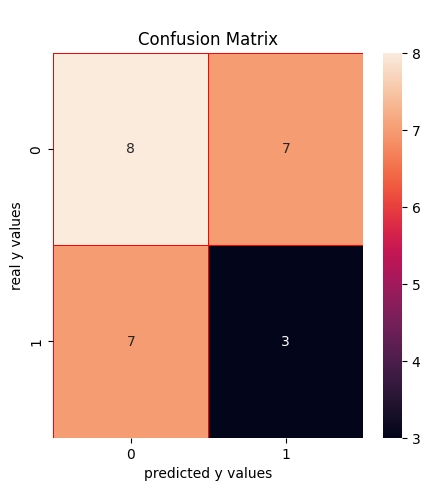

 
***** Gradient Boosting Classifier  ALGORITHM:
Score for  Gradient Boosting Classifier  train set: 1.0
Score for  Gradient Boosting Classifier  test set:  0.44
 
Accuracy: 44.00%
 
 
F1-score:  0.44
 


Recall Score of  Gradient Boosting Classifier  :  0.3
Precision Score of  Gradient Boosting Classifier  :  0.3

AUC: 0.46
AUC: 0.46


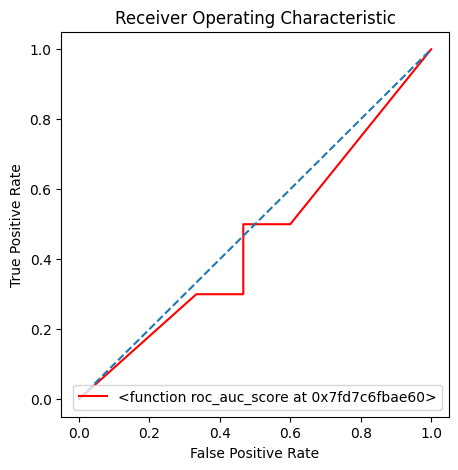

In [137]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting Classifier",
              GradientBoostingClassifier(n_estimators=15, learning_rate=0.4, max_features=20, max_depth=12, random_state=0),1)

## Neural Networks: MLP Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


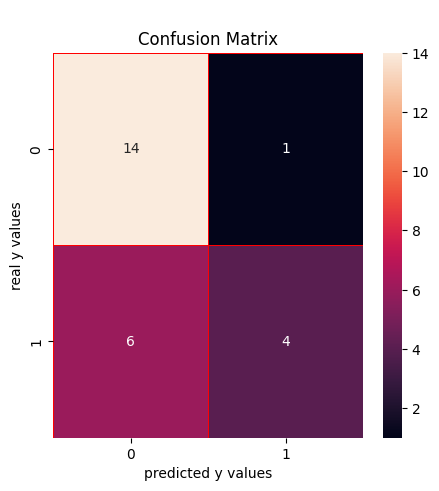

 
***** NN - MLPCLASSIFIER  ALGORITHM:
Score for  NN - MLPCLASSIFIER  train set: 0.8686868686868687
Score for  NN - MLPCLASSIFIER  test set:  0.72
 
Accuracy: 72.00%
 
 
F1-score:  0.6933333333333332
 


Recall Score of  NN - MLPCLASSIFIER  :  0.4
Precision Score of  NN - MLPCLASSIFIER  :  0.8

AUC: 0.72
AUC: 0.72


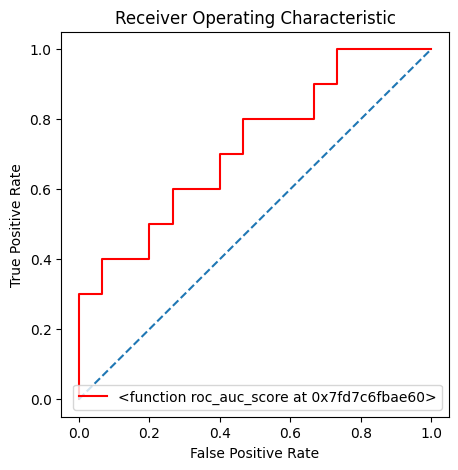

In [138]:
ML_Algorithms(X_train_scaled, X_test_scaled, y_train, y_test, "NN - MLPCLASSIFIER",
              MLPClassifier(hidden_layer_sizes=(1000, ),alpha=0.001,  learning_rate_init=0.001, power_t=0.9, max_iter=50),1)